In [1]:
import os 
import numpy as np 
from PIL import Image 
import albumentations as A 
import torch

In [2]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

In [3]:
label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]
label_files[:5]

['Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'J2_jpg.rf.454825a65d0eafdc0586a7ff687848a4.txt',
 'M4_jpg.rf.2e4ce0d9adf16aa3d33a2ba77e567416.txt',
 'T23_jpg.rf.c8c9b394fc0b451c31f76bd56357a6d0.txt',
 'L23_jpg.rf.9871c514a88ee4257f04476802731971.txt']

### In the original data.py file we have used the 'split' because we have only One dot but in my custom data I have multiple dots so to get the correct text file we have to split it from the back i.e. performe a right split 'rsplit' and taking the first part that's how we get our image base name

In [4]:
idx = 0 
label_file = label_files[idx]
image_file = label_file.rsplit('.',1)[0] + '.jpg'

label_path,image_path = os.path.join(labels_path,label_file),os.path.join(images_path,image_file)
label_path,image_path

('data/train/labels/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'data/train/images/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.jpg')

In [5]:
img = Image.open(image_path)
img_np = np.array(img)
print(img_np.shape)

(640, 480, 3)


In [6]:
annotations = open(label_path).read().strip().split(' ')
annotations

['25', '0.31875', '0.6703125', '0.3541666666666667', '0.25625']

In [7]:
annotations = open(label_path).read().strip().split('\n')
class_labels = []
bounding_boxes = []

for annotation in annotations:
    ann = annotation.split(" ")
    class_labels.append(int(ann[0]))
    bounding_boxes.append([float(x) for x in ann[1:]])

class_labels, bounding_boxes = np.array(class_labels,dtype=int), np.array(bounding_boxes,dtype=float)
class_labels, bounding_boxes

(array([25]), array([[0.31875   , 0.6703125 , 0.35416667, 0.25625   ]]))

In [8]:
transfrom = A.Compose(
    [
        A.Resize(500,500),
        A.RandomCrop(224,224,p=0.33),
        A.Resize(224,224),
        A.HorizontalFlip(p=0.6),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.pytorch.transforms.ToTensorV2()   
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

aug = transfrom(image= img_np,bboxes = bounding_boxes,class_labels = class_labels)
aug.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [9]:
aug_img = aug['image']
aug_boxes = aug['bboxes']
aug_labels = aug['class_labels']
print(aug_img.shape)
print(aug_boxes)
print(aug_labels)


torch.Size([3, 224, 224])
[[0.31875    0.67031252 0.35416667 0.25625002]]
[25]


In [10]:
aug_tensor = aug_img 
labels_tensor = torch.tensor(aug_labels,dtype=torch.long)
boxes_tensor = torch.tensor(aug_boxes,dtype=torch.float32)
# aug_tensor,labels_tensor,boxes_tensor
labels_tensor,boxes_tensor

(tensor([25]), tensor([[0.3187, 0.6703, 0.3542, 0.2563]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].


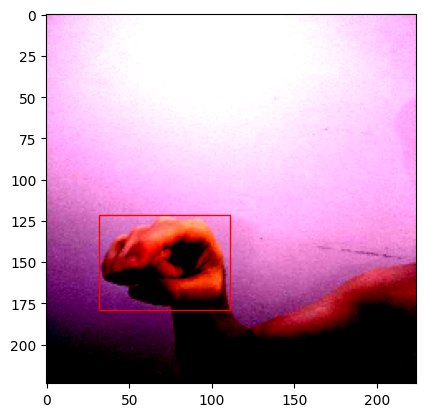

In [ ]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 

plt.imshow(aug_tensor.permute(1,2,0))
abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for box in abs_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(
        plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin,fill = False, color ='red',linewidth = 1)
    )

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].


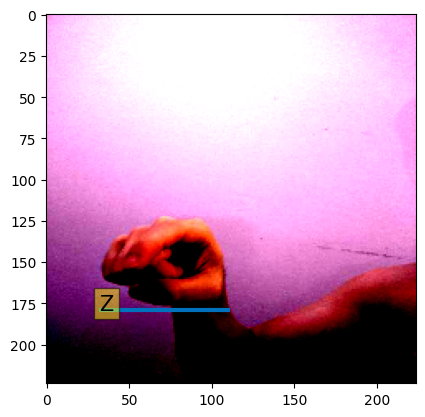

In [15]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 
from src.utils.setup import get_classes

plt.imshow(aug_tensor.permute(1,2,0))
ax = plt.gca()
CLASSES = get_classes()

abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for label,box in zip(labels_tensor,abs_boxes):
    xmin, ymin, xmax, ymin = box 
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,fill= False,color=(0.000, 0.447, 0.741),linewidth = 3))
    ax.text(xmin, ymin, f'{CLASSES[label]}', fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

plt.show()